### Signal Analysis - Compute Power Spectral Density (PSD)
This cell will calculate and plot the power spectral density (PSD) of the received signal using Welch's method. In Welch's method, signal's variance is reduced hence power spectral density can be observed to indice following aspects of the RF Signal
- Normalized signal occupied bandwidth
- Null subcarrier presence


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DC Subcarrier Null? : True
DC Subcarrier Power Ratio  : 0.3326282479343138
Number of occupied carriers : 605 / 1024
Normalized occupied bandwidth : 0.5908203125
Signal power threshold : 5.950249450608545e-10
Mean signal power : 4.437999845985695e-09


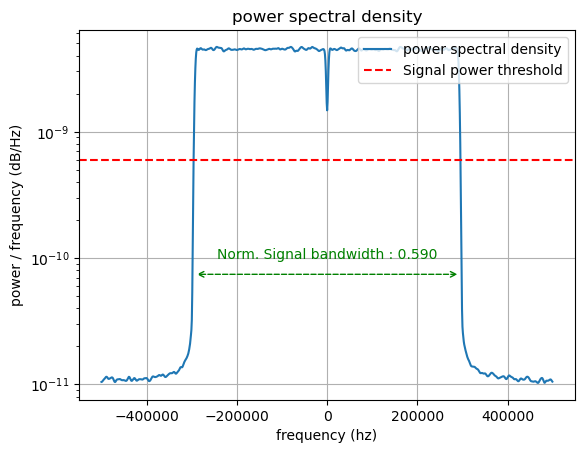

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, peak_widths, welch
import warnings
warnings.filterwarnings("ignore", message="Input data is complex, switching to return_onesided=False")

### Parameters
fft_length = 1024
sample_freq_sps = 1e6

### Computations

# Extract signal
rx_signal = np.load('rxSignal.npy')
rx_signal_len = len(rx_signal)

# Check if rx signal array is valid
if not np.iscomplexobj(rx_signal):
    raise ValueError("Rx signal must be complex array")

# Visualize power spectral density
carr_spacing_hz = sample_freq_sps / fft_length
freq_shifted, psd = welch(rx_signal, fs=sample_freq_sps, nfft=fft_length)

psd = np.roll(psd, int(fft_length/2))
freq_shifted = np.roll(freq_shifted, int(fft_length/2))


# Signal power above noise floor?
# Can PSD tell about partical occupation of bandwidth by signal?
occup_carr_threshold  = (np.max(psd) - np.min(psd)) * 0.125 + np.min(psd)

num_occupied_carriers = np.sum(psd > occup_carr_threshold)
occupied_carr_indices = np.where(psd > occup_carr_threshold)[0]
occupied_band_start_hz = occupied_carr_indices[0] * carr_spacing_hz - sample_freq_sps * 0.5
occupied_band_end_hz   = occupied_carr_indices[-1] * carr_spacing_hz - sample_freq_sps * 0.5
occupied_bandwidth_norm = (occupied_band_end_hz - occupied_band_start_hz)/sample_freq_sps

# NUll subcarrier present? 
# Answer: To find out, a rule of thumb could be applied that in case of flat fading channel,
# DC subcarrier power in PSD is atleast 3 times smaller than average signal power across signal bandwidth
mean_signal_power = np.mean(psd[occupied_carr_indices[0]:occupied_carr_indices[-1]])
is_dc_subcarrier_null = psd[int(fft_length/2)] < 0.35 * mean_signal_power

print(f"DC Subcarrier Null? : {is_dc_subcarrier_null}")
print(f"DC Subcarrier Power Ratio  : {psd[int(fft_length/2)] / np.mean(psd[occupied_carr_indices[0]:occupied_carr_indices[-1]])}")


print(f"Number of occupied carriers : {num_occupied_carriers} / {fft_length}")
print(f"Normalized occupied bandwidth : {num_occupied_carriers / len(psd)}")
print(f"Signal power threshold : {occup_carr_threshold}")
print(f"Mean signal power : {mean_signal_power}")

plt.figure()
plt.semilogy(freq_shifted, psd, label='power spectral density')
plt.axhline(y=occup_carr_threshold, color='r', linestyle='--', label='Signal power threshold')
plt.annotate('',
             xy=(occupied_band_start_hz, occup_carr_threshold/8),
             xytext=(occupied_band_end_hz, occup_carr_threshold/8),
             arrowprops=dict(arrowstyle='<->', linestyle='--', color='green'), label='Signal occupied band')
plt.text((occupied_band_start_hz + occupied_band_end_hz) / 2, occup_carr_threshold/6, 
         f"Norm. Signal bandwidth : {occupied_bandwidth_norm:.3f}", color='green', ha='center')

plt.title("power spectral density")
plt.xlabel("frequency (hz)")
plt.ylabel("power / frequency (dB/Hz)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


### Signal Analysis - Detect CP and FFT Lengths using CP Correlation
This cell will use CP correlation algorithm to detect following parameters
- CP length $N_{CP}$
- FFT length $N_{FFT}$
- Fine frequency offset $f_{err} \le \Delta{f} = F_s / N_{FFT}$

Iterating over fft length = 512
Iterating over fft length = 1024
Iterating over fft length = 2048
Iterating over fft length = 4096


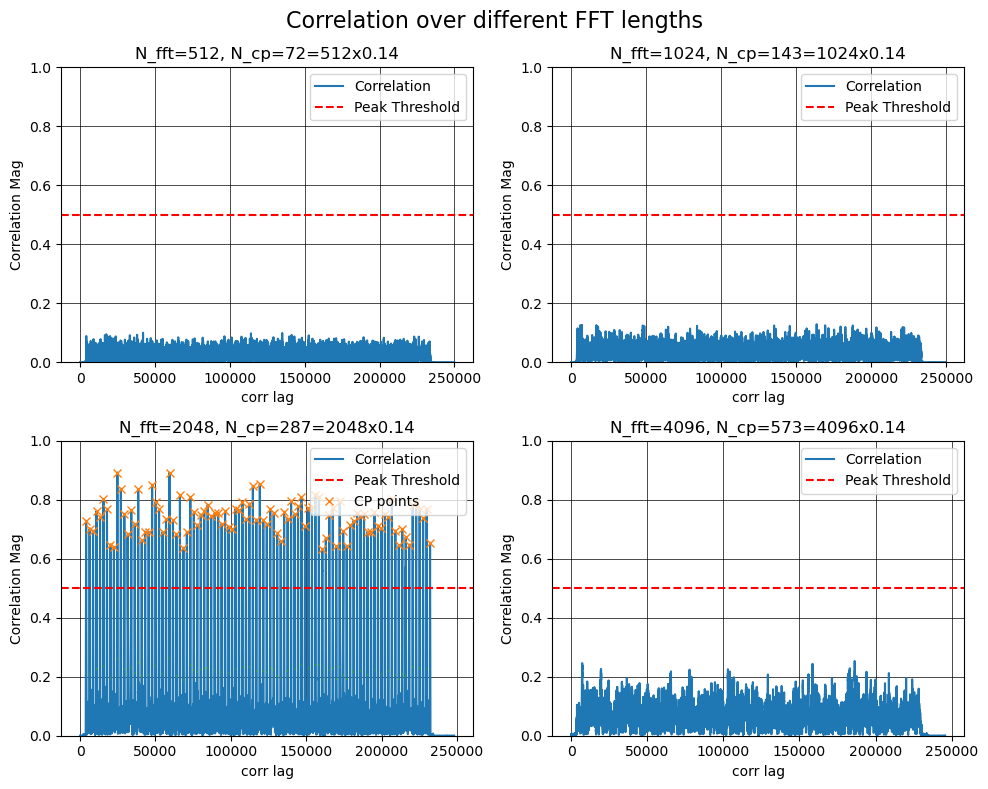

Iterating over cp length = 160
Iterating over cp length = 192
Iterating over cp length = 224
Iterating over cp length = 256
Iterating over cp length = 288
Iterating over cp length = 320
Iterating over cp length = 352


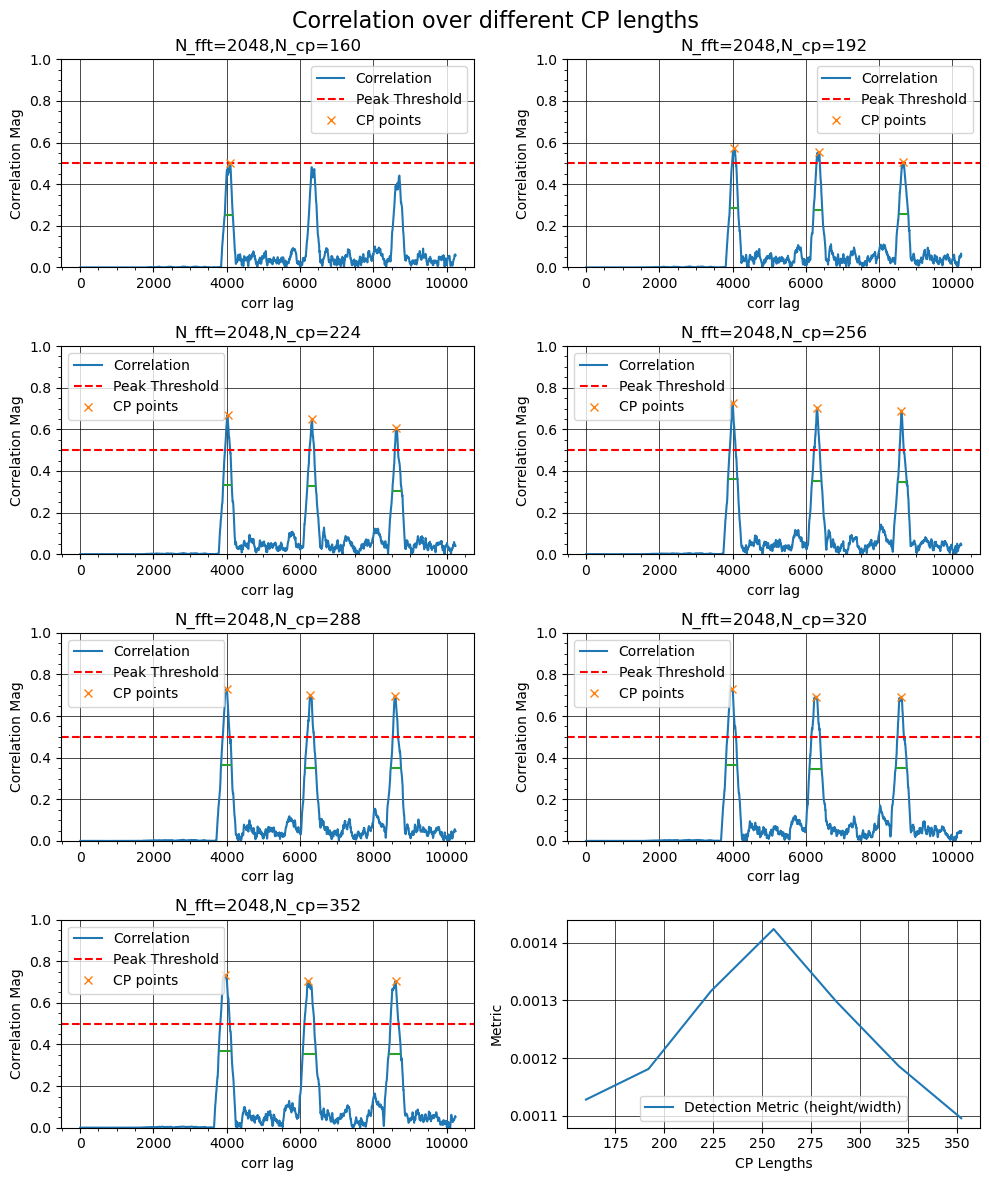

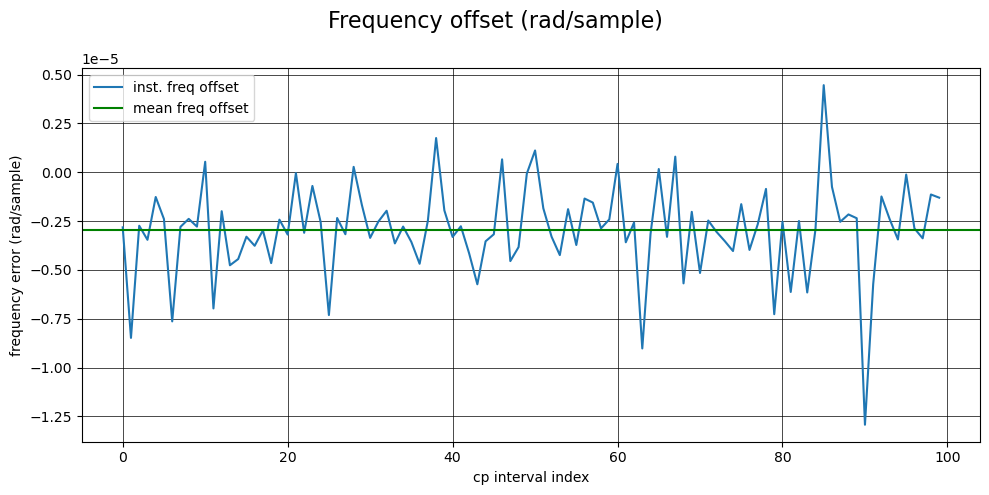

Detected FFT length  = 2048
Detected CP length   = 256
Detected freq offset = -2.938435060341799e-06 rad/sample


In [2]:
# Iterate over possible FFT legnths and check if CP correlation 
# gives 'sensible' output for any of them! Assuming CP length to be
# closer to 15% of FFT length
detected_fft_len = 0
candidate_fft_len = np.array([2**i for i in range(9, 13)])
candidate_cp_len = np.round(candidate_fft_len * 0.14)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
fig.suptitle('Correlation over different FFT lengths', fontsize=16)

b, a = butter(N=4, Wn=0.15, btype='low')  # Design a 4th order low-pass filter with cutoff at 25% of fs

# Find FFT Length
# CP Correlation across fft lengths
corr_fft_profile = []
for idx, fft_len in enumerate(candidate_fft_len):
    print(f"Iterating over fft length = {fft_len}")

    corr_profile = []
    cp_len = int(candidate_cp_len[idx])
    for lag in range(rx_signal_len - cp_len - fft_len):
        block_1 = rx_signal[lag:lag+cp_len]
        block_2 = rx_signal[lag + fft_len : lag + fft_len + cp_len]
        corr    = np.abs(np.sum(block_1 * np.conjugate(block_2)))
        corr_profile.append(corr)

    corr_fft_profile.append(np.array(corr_profile))
    corr_fft_profile[idx] = filtfilt(b, a, corr_fft_profile[idx])
    corr_profile = filtfilt(b, a, corr_profile)

    # Check if peaks detected in correlation 
    peaks, properties = find_peaks(corr_profile, height=0.5)

    axs[idx].plot(corr_profile, label="Correlation")
    axs[idx].axhline(y=0.5, color='red', linestyle='--', label="Peak Threshold")
    axs[idx].set_title(f'N_fft={fft_len}, N_cp={cp_len}={fft_len}x0.14')
    axs[idx].set_xlabel('corr lag')
    axs[idx].set_ylabel('Correlation Mag')
    axs[idx].set_ylim(0, 1)
    axs[idx].grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    axs[idx].legend()

    if len(peaks) == 0:
        continue
    else:
        detected_fft_len = fft_len
        # Remove spurious peaks
        min_width = int(cp_len*0.3)
        widths = peak_widths(corr_profile, peaks, rel_height=0.5)
        valid_peaks = peaks[widths[0] >= min_width]
        valid_widths = peak_widths(corr_profile, valid_peaks, rel_height=0.707)

        # Plot the signal with peaks, heights, and widths
        #axs[idx].plot(corr_fft_profile[idx])
        axs[idx].plot(valid_peaks, corr_profile[valid_peaks], "x", label="CP points")
        axs[idx].hlines(*valid_widths[1:], color="C2")
        axs[idx].legend()
plt.tight_layout()
plt.show()

# Find CP length 
# CP Correlation across CP lengths
if detected_fft_len != 0:
    # Checck
    candidate_cp_len = np.arange(160, 384, 32)

    fig, axs = plt.subplots(4, 2, figsize=(10, 12))
    axs = axs.flatten()
    fig.suptitle('Correlation over different CP lengths', fontsize=16)

    # Plot peaks for better visualization
    offset=0
    lenn=5

    idces_to_plot = np.arange(offset*detected_fft_len, offset*detected_fft_len+lenn*detected_fft_len, 1)
    #rx_signal = rx_signal[offset*detected_fft_len:offset*detected_fft_len+lenn*detected_fft_len]
    #rx_signal_len = lenn*detected_fft_len
    
    # Find closest CP length 
    # i.e. the one which minimizes plateau (win len == cp len)
    corr_cp_profile = []
    corr_cp_detect_metric = []
    corr_peak_mean_height = []
    corr_peak_mean_width  = []
    for idx, cp_len in enumerate(candidate_cp_len):
        print(f"Iterating over cp length = {cp_len}")

        corr_profile = []
        for lag in range(rx_signal_len - cp_len - detected_fft_len):
            block_1 = rx_signal[lag : lag + cp_len]
            block_2 = rx_signal[lag + detected_fft_len : lag + detected_fft_len + cp_len]
            corr    = np.sum(block_1 * np.conjugate(block_2))
            corr_profile.append(corr)    
            
        corr_cp_profile.append(np.array(corr_profile))
        corr_cp_profile[idx] = filtfilt(b, a, corr_cp_profile[idx])
        corr_profile = filtfilt(b, a, corr_profile)
        corr_profile = np.abs(corr_profile)
    
        # Check if peaks detected in correlation
        # Remove spurious peaks
        peaks, properties = find_peaks(corr_profile, height=0.5)
        min_width = int(cp_len*0.3)
        widths = peak_widths(corr_profile, peaks, rel_height=0.5)
        valid_peaks = peaks[widths[0] >= min_width]
        valid_widths = peak_widths(corr_profile, valid_peaks, rel_height=0.5)

        # Calculate isosceles triangle similarity metric
        # i.e. the peak matching isosceles triangle with highest ratio of height to base
        # has it's width at 0.5 x height equal to CP length.
        # 1. When corr window length < cp length, corr mag height and width is lesser than CP length -> ratio is small
        # 2. When corr window length == cp length, corr mag height is max and width is equal to CP length -> ratio is large
        # 3. When corr window length > cp length, corr mag height is max and width is greater to CP length -> ratio is small
        corr_cp_detect_metric.append(np.mean(valid_widths[1]) / np.mean(valid_widths[0]))

        axs[idx].plot(corr_profile[idces_to_plot], label="Correlation")
        axs[idx].axhline(y=0.5, color='red', linestyle='--', label="Peak Threshold")
        axs[idx].set_title(f'N_fft={detected_fft_len},N_cp={cp_len}')
        axs[idx].set_xlabel('corr lag')
        axs[idx].set_ylabel('Correlation Mag')
        axs[idx].set_ylim(0, 1)
        axs[idx].grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
        axs[idx].minorticks_on()
        axs[idx].legend()

        # Plot the signal with peaks, heights, and widths
        peaks, properties = find_peaks(corr_profile[idces_to_plot], height=0.5)
        min_width = int(cp_len*0.3)
        widths = peak_widths(corr_profile[idces_to_plot], peaks, rel_height=0.5)
        valid_peaks_plot = peaks[widths[0] >= min_width]
        valid_widths_plot = peak_widths(corr_profile[idces_to_plot], valid_peaks_plot, rel_height=0.5)
        axs[idx].plot(valid_peaks_plot, corr_profile[idces_to_plot][valid_peaks_plot], "x", label="CP points")
        axs[idx].hlines(*valid_widths_plot[1:], color="C2")
        axs[idx].legend()


    axs[len(candidate_cp_len)].plot(candidate_cp_len, corr_cp_detect_metric, label="Detection Metric (height/width)")
    axs[len(candidate_cp_len)].set_xlabel('CP Lengths')
    axs[len(candidate_cp_len)].set_ylabel('Metric')
    axs[len(candidate_cp_len)].grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    axs[len(candidate_cp_len)].legend()

    plt.tight_layout()
    plt.show()

    detected_cp_idx  = np.argmax(corr_cp_detect_metric)
    detected_cp_len  = candidate_cp_len[detected_cp_idx]
    detected_freq_error = np.mean(np.angle(corr_cp_profile[detected_cp_idx][valid_peaks]) / (2 * np.pi * (detected_fft_len+detected_cp_len)))

    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Frequency offset (rad/sample)', fontsize=16)
    axs.plot(np.divide(np.angle(corr_cp_profile[detected_cp_idx][valid_peaks]), (2 * np.pi* (detected_fft_len+detected_cp_len))), label="inst. freq offset")
    axs.axhline(y=detected_freq_error, color='green', label="mean freq offset")    
    axs.set_xlabel('cp interval index')
    axs.set_ylabel('frequency error (rad/sample)')
    axs.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    axs.legend()
    plt.tight_layout()
    plt.show()

    print(f"Detected FFT length  = {detected_fft_len}")
    print(f"Detected CP length   = {detected_cp_len}")
    print(f"Detected freq offset = {detected_freq_error} rad/sample")

    


### Signal Analysis - Post FFT Analysis
This cell will extract OFDM symbols after discarding CP samples, perform FFT and analyze constellation

Detected Modulation Scheme is 16 QAM
Number of OFDM symbols present in data set = 100
Central 1200 subcarriers are occupied except DC subcarrier (two sided spectrum)
Number occupied subcarriers for OFDM symbol 0 = 1198/2048
Number occupied subcarriers for OFDM symbol 1 = 1198/2048
Number occupied subcarriers for OFDM symbol 2 = 1198/2048
Number occupied subcarriers for OFDM symbol 3 = 1198/2048
Number occupied subcarriers for OFDM symbol 4 = 1198/2048
Number occupied subcarriers for OFDM symbol 5 = 1198/2048
Number occupied subcarriers for OFDM symbol 6 = 1199/2048
Number occupied subcarriers for OFDM symbol 7 = 1198/2048
Number occupied subcarriers for OFDM symbol 8 = 1198/2048
Number occupied subcarriers for OFDM symbol 9 = 1198/2048
Number occupied subcarriers for OFDM symbol 10 = 1198/2048
Number occupied subcarriers for OFDM symbol 11 = 1198/2048


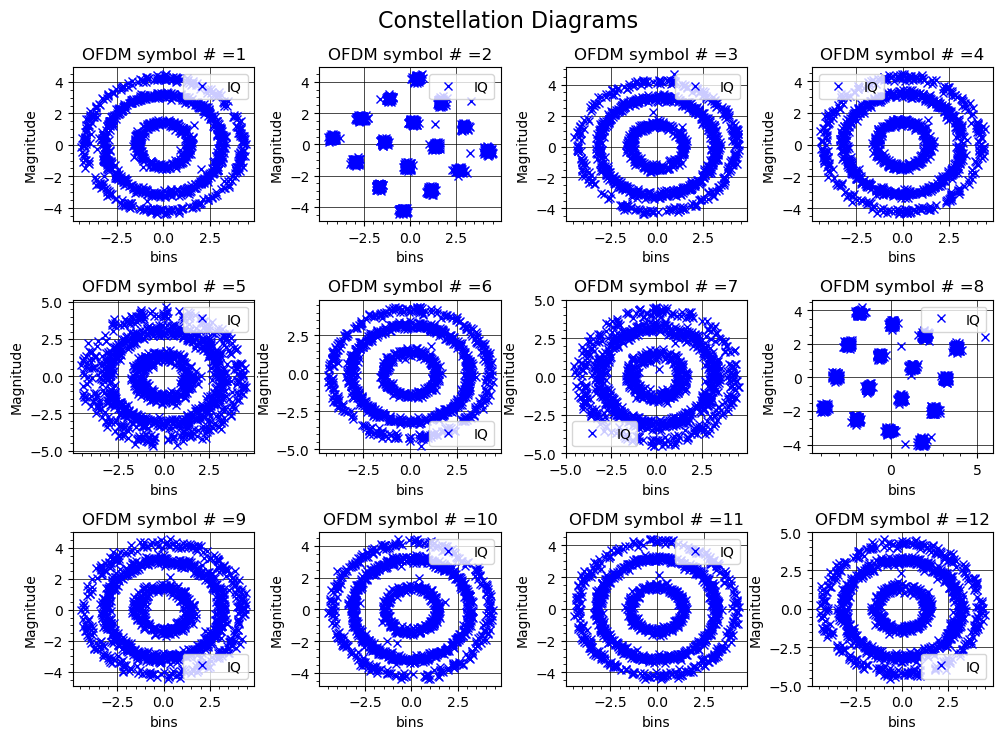

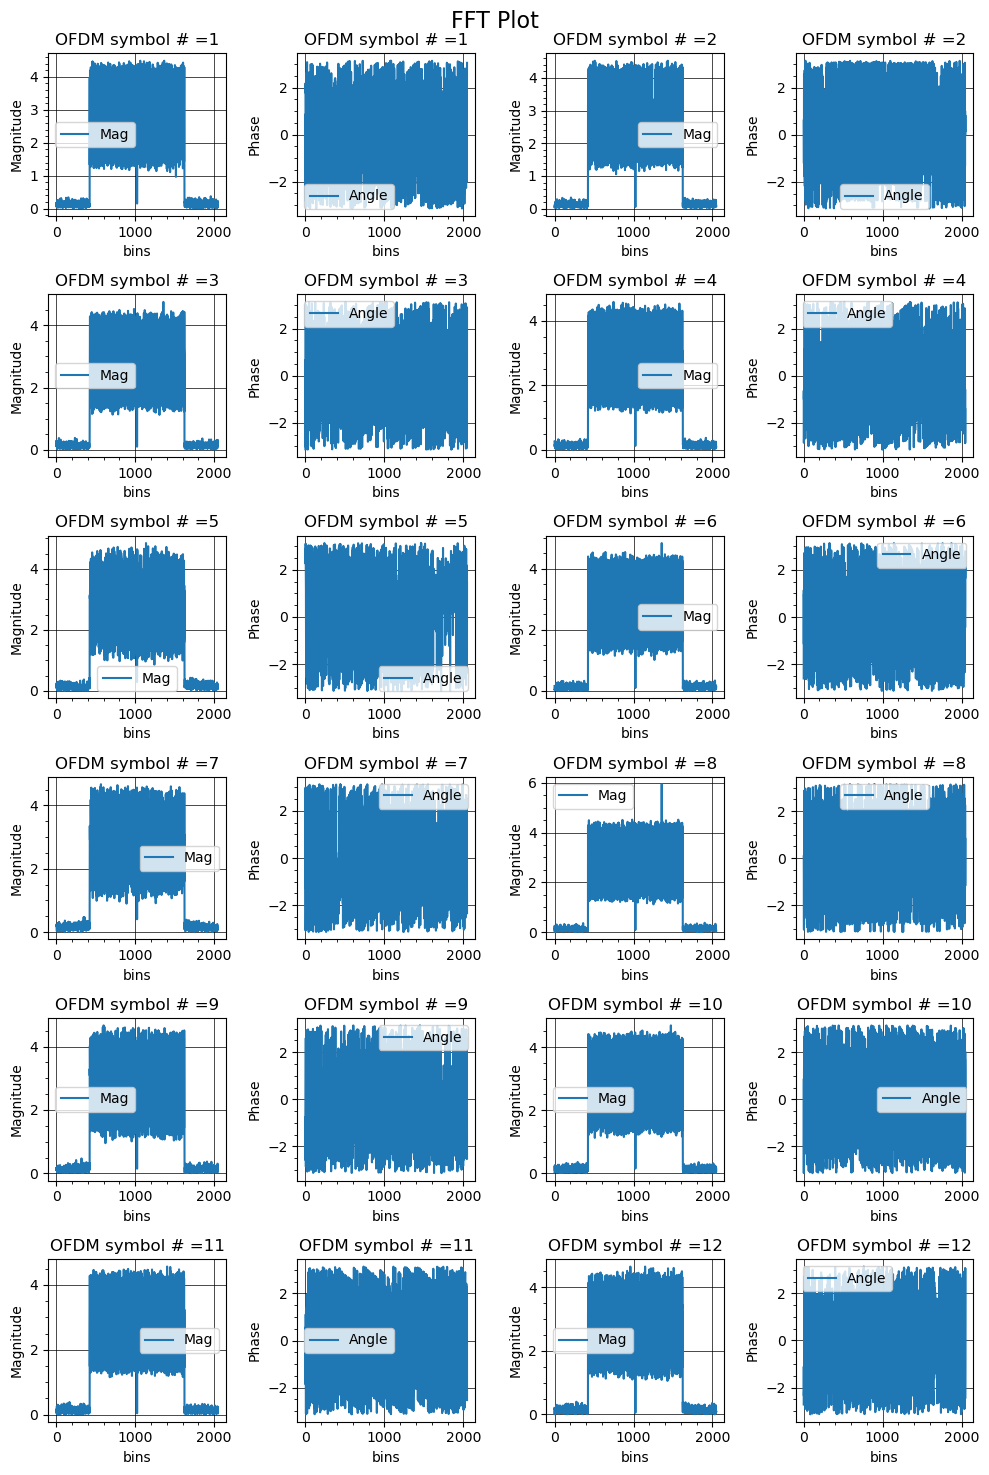

In [12]:
# Extract CP locations of the symbols
corr_profile = np.abs(corr_cp_profile[detected_cp_idx])
peaks,properties  = find_peaks(corr_profile, height=0.5)
widths = peak_widths(corr_profile, peaks, rel_height=0.5)
cp_start_indices = peaks[widths[0] >= min_width]

num_ofdm_symbols = len(cp_start_indices)
# Just plot 12 symbols
num_ofdm_symbols = 12

num_cols = 4
num_rows = ((num_ofdm_symbols + num_cols - 1) // num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 2.5*num_rows))
axs = axs.flatten()
fig.suptitle('Constellation Diagrams', fontsize=16)

# Correct frequency offset
correction_signal = np.exp(1j * (2 * np.pi * -detected_freq_error * np.arange(rx_signal_len)))
rx_signal2 = rx_signal * correction_signal

print(f"Detected Modulation Scheme is 16 QAM")
print(f"Number of OFDM symbols present in data set = {len(cp_start_indices)}")
print(f"Central 1200 subcarriers are occupied except DC subcarrier (two sided spectrum)")

# Extract OFDM symbols
for symb_idx in range(num_ofdm_symbols):
    curr_symb_start = cp_start_indices[symb_idx]+detected_cp_len
    td_symb = rx_signal2[curr_symb_start:curr_symb_start+detected_fft_len]
    
    fd_symb = np.fft.fft(td_symb)
    fd_symb = np.fft.fftshift(fd_symb)
    subcarrier_idces = np.arange(detected_fft_len)
    subcarrier_idces = subcarrier_idces[np.abs(fd_symb) > 0.5]

    subcarrier_fd_symb = fd_symb[subcarrier_idces]

    print(f"Number occupied subcarriers for OFDM symbol {symb_idx} = {len(subcarrier_fd_symb)}/{detected_fft_len}")    
    axs[symb_idx].plot(np.real(subcarrier_fd_symb), np.imag(subcarrier_fd_symb), 'x',color='blue', label="IQ")
    axs[symb_idx].set_title(f'OFDM symbol # ={symb_idx+1}')
    axs[symb_idx].set_xlabel('bins')
    axs[symb_idx].set_ylabel('Magnitude')
    axs[symb_idx].grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    axs[symb_idx].minorticks_on()
    axs[symb_idx].legend()

plt.tight_layout()
plt.show()

fig1, axs1 = plt.subplots(num_rows*2, num_cols, figsize=(10, 5*num_rows))
axs1 = axs1.flatten()
fig1.suptitle('FFT Plot', fontsize=16)


for symb_idx in range(num_ofdm_symbols):
    curr_symb_start = cp_start_indices[symb_idx]+detected_cp_len
    td_symb = rx_signal2[curr_symb_start:curr_symb_start+detected_fft_len]
    fd_symb = np.fft.fft(td_symb)
    fd_symb = np.fft.fftshift(fd_symb)

    axs1[2*symb_idx].plot(np.abs(fd_symb), label="Mag")
    axs1[2*symb_idx].set_title(f'OFDM symbol # ={symb_idx+1}')
    axs1[2*symb_idx].set_xlabel('bins')
    axs1[2*symb_idx].set_ylabel('Magnitude')
    axs1[2*symb_idx].grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    axs1[2*symb_idx].minorticks_on()
    axs1[2*symb_idx].legend()

    axs1[2*symb_idx+1].plot(np.angle(fd_symb), label="Angle")
    axs1[2*symb_idx+1].set_title(f'OFDM symbol # ={symb_idx+1}')
    axs1[2*symb_idx+1].set_xlabel('bins')
    axs1[2*symb_idx+1].set_ylabel('Phase')
    axs1[2*symb_idx+1].grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    axs1[2*symb_idx+1].minorticks_on()
    axs1[2*symb_idx+1].legend()
plt.tight_layout()
plt.show()

    